## Create Data Annotation CSV File

## Arguments

In [1]:
# Paths
ps_result_path = '/content/drive/MyDrive/ISIMA/Research Project/Background Detection/src/Semantic Segmentation/Results/PointRend'
save_ps_imgs_path = '/content/drive/MyDrive/ISIMA/Research Project/Background Detection/src/Semantic Segmentation/Results/PointRend/images'
annot_csv_path = 'annotations.csv'
data_path = '/content/drive/MyDrive/ISIMA/Research Project/Background Detection/src/Datasets/data'

# Constants
batch_size = 32
run_test = False
NB_IMAGES = 20

## Setup Environment

In [2]:
# Install specific version of PyYAML
!python -m pip install pyyaml==5.1

# Import necessary libraries
import sys
import os
import distutils.core

# Clone Detectron2 repository
!git clone 'https://github.com/facebookresearch/detectron2'

# Run setup.py to obtain installation requirements
dist = distutils.core.run_setup("./detectron2/setup.py")

# Install dependencies
!python -m pip install {' '.join(dist.install_requires)}

# Add Detectron2 to the system path
sys.path.insert(0, os.path.abspath('./detectron2'))

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


In [3]:
# Import necessary libraries
import torch
import detectron2

# Check CUDA version
!nvcc --version

# Get Torch and CUDA version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]

# Print Torch and CUDA version
print("Torch:", TORCH_VERSION, "; CUDA:", CUDA_VERSION)

# Print Detectron2 version
print("Detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import common libraries
import numpy as np
import os
import json
import cv2
import random
from google.colab.patches import cv2_imshow
import pickle
import imutils
import matplotlib.pyplot as plt
import pandas as pd

# Import common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from google.colab import drive
drive.mount('/content/drive')

## Utils

### 1. Panoptic Model

In [5]:
def load_cfg(path="COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"):
    """
    Load configuration file for Detectron2 model and create predictor object.

    Args:
    - path (str): Path to the configuration file. Default is COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml.

    Returns:
    - cfg (detectron2.config.CfgNode): Configuration object.
    - predictor (detectron2.engine.defaults.DefaultPredictor): Predictor object.
    """
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(path))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(path)
    predictor = DefaultPredictor(cfg)

    return cfg, predictor

In [6]:
def visualize(im, cfg, predictor, output_dir=None, filename=None, save=False):
    """
    Visualize panoptic segmentation predictions on an image.

    Args:
    - im (numpy.ndarray): Input image.
    - cfg (detectron2.config.CfgNode): Configuration object.
    - predictor (detectron2.engine.defaults.DefaultPredictor): Predictor object.
    - output_dir (str): Directory to save the output image. Default is None.
    - filename (str): Name of the output image file. Default is None.
    - save (bool): Whether to save the output image. Default is False.

    Returns:
    - panoptic_seg (torch.Tensor): Panoptic segmentation result.
    - segments_info (list): Information about segments.
    - out (detectron2.utils.visualizer.Visualizer): Visualizer object.
    """
    # Inference with a panoptic segmentation model
    panoptic_seg, segments_info = predictor(im)["panoptic_seg"]

    # Create a visualizer for the original image with relative information of different classes
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

    # Create an output image in which the segmentation zone is added
    out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)

    if save:
        # Save the image to the output directory
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

    # Show the image
    cv2_imshow(out.get_image()[:, :, ::-1])

    return panoptic_seg, segments_info, out

### 2. Data Processing

In [7]:
def read_images_from_directory(directory):
    """
    Read images from a directory and convert them to RGB and BGR formats.

    Args:
    - directory (str): Path to the directory containing images.

    Returns:
    - image_list_rgb (list): List of RGB images.
    - image_list_bgr (list): List of BGR images.
    - file_names (list): List of filenames corresponding to the images.
    """
    image_list_rgb = []
    image_list_bgr = []
    file_names = []

    for filename in os.listdir(directory):
        img_bgr = cv2.imread(os.path.join(directory, filename))
        if img_bgr is not None:
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            image_list_bgr.append(img_bgr)
            image_list_rgb.append(img_rgb)
            file_names.append(filename)

    return image_list_rgb, image_list_bgr, file_names


In [8]:
def show_images(image_list, title):
    """
    Display a grid of images.

    Args:
    - image_list (list): List of images to display.
    - title (str): Title for the plot.
    """
    fig = plt.figure(figsize=(10, 5))
    columns = 5
    rows = (len(image_list) + columns - 1) // columns
    for i in range(len(image_list)):
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.imshow(image_list[i])
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

In [10]:
def open_pickled_files(folder=ps_result_path):
    """
    Load data from all pickle files in a specified folder.

    Args:
    - folder (str): Path to the folder containing pickle files. Default is ps_result_path.

    Returns:
    - loaded_data_list (list): List of loaded data from pickle files.
    """
    # Get a list of all files in the specified folder
    file_list = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

    # Initialize an empty list to store loaded data
    loaded_data_list = []

    # Loop through each file and load its data
    for file_name in file_list:
        file_path = os.path.join(folder, file_name)
        # Check if the file is a pickle file
        if file_name.endswith('.pkl'):
            with open(file_path, 'rb') as pickle_file:
                # Load the data from the pickle file and append it to the list
                loaded_data_list.append(pickle.load(pickle_file))

    return loaded_data_list

## Import and Visualize the Data

In [12]:
# Read images from the specified directory
image_rgb, image_bgr, file_names = read_images_from_directory(data_path)

# Calculate the number of images loaded
num_examples = len(file_names)

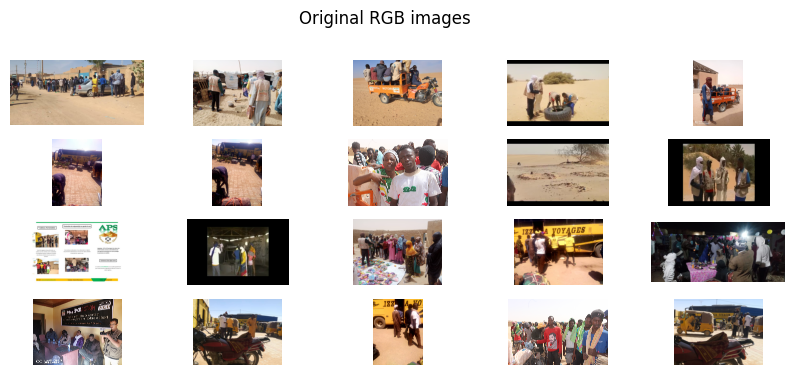

In [13]:
show_images(image_rgb[:NB_IMAGES], "Original RGB images")

## Use Panoptic Model

In [14]:
cfg, predictor = load_cfg()

[03/10 17:52:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


In [15]:
def save_ps_results(imgs, ps_result_path):
    """
    Save results of panoptic segmentation in batches to pickle files.

    Args:
    - imgs (list): List of images to process.
    - ps_result_path (str): Path to save the results.

    Returns:
    - None
    """
    # Calculate the number of examples
    num_examples = len(imgs)

    # Initialize a dictionary to store results
    results = dict()

    # Iterate over the images and save in batches
    for i in range(0, num_examples, batch_size):
        batch_results = dict()

        # Process images in the current batch
        for j in range(i, min(i + batch_size, num_examples)):
            # Resize image for processing
            im = imutils.resize(imgs[j], width=640)
            # Convert image to float32
            im = im.astype(np.float32)
            # Perform panoptic segmentation and visualization
            panoptic_seg, segments_info, out = visualize(im, cfg, predictor)
            # Store results for the current image
            batch_results[file_names[j]] = [out, panoptic_seg, segments_info]

        # Save the batch results to a pickle file
        batch_file_path = os.path.join(ps_result_path, f'point_rend_batch_{i // batch_size}.pkl')
        with open(batch_file_path, 'wb') as pickle_file:
            pickle.dump(batch_results, pickle_file)

        # Print information about the saved batch
        print(f'Batch {i // batch_size} saved to {batch_file_path}')

    # Print a message indicating successful saving of all batches
    print('All batches saved successfully.')


In [16]:
if run_test:
  save_ps_results(image_bgr, ps_result_path)

## Create Label Categories

In [17]:
del image_rgb
del image_bgr

In [18]:
# Get stuff dataset id keys and values
stuff_id_keys = list(predictor.metadata.stuff_dataset_id_to_contiguous_id.keys())
stuff_id_values = list(predictor.metadata.stuff_dataset_id_to_contiguous_id.values())

# Get thing dataset id keys and values
thing_id_keys = list(predictor.metadata.thing_dataset_id_to_contiguous_id.keys())
thing_id_values = list(predictor.metadata.thing_dataset_id_to_contiguous_id.values())

# Combine stuff and thing keys
coco_stuff_label_keys = stuff_id_keys + thing_id_keys

# Combine stuff and thing values
coco_stuff_label_values = predictor.metadata.stuff_classes + predictor.metadata.thing_classes

# Create a dictionary of Coco stuff labels
coco_stuff_labels = dict(zip(coco_stuff_label_keys, coco_stuff_label_values))
coco_stuff_labels = dict(sorted(coco_stuff_labels.items()))

In [19]:
# Create DataFrame for Stuff classes
stuff_df = pd.DataFrame({"Node": predictor.metadata.stuff_classes, "type": "stuff"})

# Create DataFrame for Thing classes
thing_df = pd.DataFrame({"Node": predictor.metadata.thing_classes, "type": "thing"})

# Combine Stuff and Thing DataFrames
label_categories = pd.concat([stuff_df, thing_df], axis=0)

# Export label categories to a CSV file
label_categories.to_csv("label_categories.csv", index=True)

## Create te Annotation Matrix

In [20]:
# Upload the panoptic segmentation results
ps_result_batches = open_pickled_files(folder=ps_result_path)

point_rend_batch_0.pkl
point_rend_batch_1.pkl
point_rend_batch_2.pkl
point_rend_batch_3.pkl
point_rend_batch_4.pkl
point_rend_batch_5.pkl
result.csv


In [21]:
def annotation(ps_result_batches, columns, save_path, save_results=False, show_image=False):
    """
    Annotate the Panoptic Segmentation results.

    Args:
    - ps_result_batches (list): List of dictionaries containing Panoptic Segmentation results.
    - columns (list): List of column names for the annotation matrix.
    - save_path (str): Path to save the resulted images (if save_results is True).
    - save_results (bool): Whether to save the resulted images. Default is False.
    - show_image (bool): Whether to show the images during processing. Default is False.

    Returns:
    - annot_df (pd.DataFrame): Annotation matrix in the format of a DataFrame.
    """
    # Create an annotation matrix in the format of a DataFrame
    annot_mat = np.zeros((num_examples, len(coco_stuff_label_keys))).astype(int)
    annot_df = pd.DataFrame(annot_mat, index=file_names, columns=coco_stuff_label_keys)
    num_batches = len(ps_result_batches)

    # Iterate over the batches
    for i in range(num_batches):
        # Iterate over the images in each batch
        for key, value in ps_result_batches[i].items():
            # Get the segmented image
            im = value[0]
            image_rgb = cv2.cvtColor(im.get_image()[:, :, ::-1], cv2.COLOR_RGB2BGR)

            # Show the image if requested
            if show_image:
                cv2_imshow(im.get_image()[:, :, ::-1])

            # Save the resulted images (original + mask) if requested
            if save_results:
                cv2.imwrite(os.path.join(save_path, key), image_rgb)

            # Get the list of objects in a certain image and related information for each object
            info = value[2]

            # Iterate over all the objects in the list "info"
            for j in range(len(info)):
                if info[j]["isthing"]:
                    index = thing_id_keys[thing_id_values.index(info[j]["category_id"])]
                else:
                    index = stuff_id_keys[stuff_id_values.index(info[j]["category_id"])]

                # Update the annotation matrix
                annot_df.loc[key, index] = 1

    # Set column names for the annotation matrix
    annot_df.columns = columns

    return annot_df


In [22]:
# Annotate the Panoptic Segmentation results and store them in a DataFrame named annot_df
annot_df = annotation(ps_result_batches, columns=coco_stuff_label_values, save_path=save_ps_imgs_path)

In [23]:
# Save the annotation DataFrame to a CSV file
annot_df.to_csv(annot_csv_path, index=True)